In [1]:
#importing libs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [2]:
def gen_signal(N, x0, w, A, bkg, sigma, peak=False):
    x = np.arange(N)
    y = np.ones(N) * bkg
    
    if peak:
        y_peak = np.exp(-(x-x0)/w) * A
        y_peak[:x0] = 0
        y += y_peak
        
    #y = np.random.poisson(y)
    y = np.random.normal(y, sigma)

    return x, y

In [3]:
#random constant vales

#Number of data
N_data = 10000
df = pd.DataFrame(columns=["x0", "w", "A", "bkg", "sigma", "GRB"], index=range(N_data))

for i in range(N_data):
    df["x0"].loc[i] = 64 #np.random.randint(10, 50)
    df["w"].loc[i] = np.random.uniform(5, 15)
    df["A"].loc[i] = np.random.uniform(5, 15)
    df["bkg"].loc[i] = np.random.uniform(3, 8)
    df["sigma"].loc[i] = np.random.uniform(1, 5)
    df["GRB"].loc[i] = np.random.choice([True, False], p=[0.5, 0.5]) #[np.random.randint(2)]
    
df

,x0,w,A,bkg,sigma,GRB
0,64,6.250298,14.072681,7.738845,1.241408,True
1,64,6.291843,5.298765,3.002644,1.619133,False
2,64,9.669539,6.267876,4.07844,2.101165,True
3,64,9.873017,13.823652,5.537815,3.902499,True
4,64,11.980128,5.39772,7.421444,1.40614,False
...,...,...,...,...,...,...
9995,64,6.120533,12.310265,6.219977,3.873541,True
9996,64,11.851058,8.266641,3.348273,2.565342,False
9997,64,11.51679,8.298335,5.011915,1.080176,True
9998,64,10.041662,10.412953,5.045814,1.292808,True


In [4]:
#generating random data

#duration of peak window
N_tu = 128

data = []
for i in range(N_data):
    data.append(gen_signal(N=N_tu, 
                           x0=df.x0.loc[i], 
                           w=df.w.loc[i], 
                           A=df.A.loc[i], 
                           bkg=df.bkg.loc[i],
                           sigma=df.sigma.loc[i],
                           peak=df.GRB.loc[i])[1])

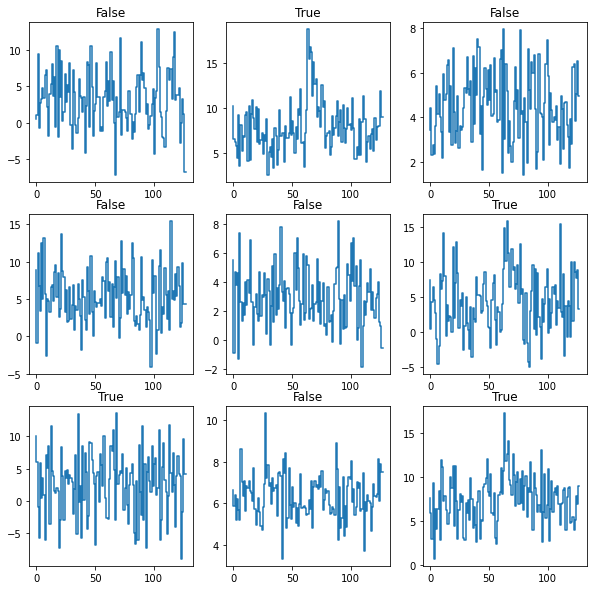

In [5]:
#plot of some curves
x = np.arange(N_tu)

fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        ind = np.random.randint(len(df.GRB))
        axs[i,j].set_title(df.GRB.loc[ind])
        axs[i,j].step(x, data[ind])

In [6]:
X = np.array(data).reshape(-1, int(N_tu))
#X = np.array(data).reshape(-1, N_tu, 1).astype(np.float32)
y = df.GRB

#encode target labels with value between 0 and n_classes-1
le = LabelEncoder()

#fit label encoder
le.fit(y)

#transform labels to normalized encoding (True = 1, False = 0)
y = le.transform(y) 

#splits data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420)

## **Dense**

In [7]:
array = Input(shape=(128,))
l1 = Dense(64, activation="relu")(array)
l2 = Dense(32, activation="relu")(l1)
encoded = Dense(8, activation='relu')(l2)
l3 = Dense(32, activation="relu")(encoded)
l4 = Dense(64, activation="relu")(l3)
decoded = Dense(128, activation="relu")(l4)

autoencoder = Model(array, decoded)

## **Convolutional**

In [8]:
# input = Input(shape=(128, 1))

# # Encoder
# x = Conv1D(32, 3, activation="relu", padding="same")(input)
# x = MaxPooling1D(2, padding="same")(x)
# #x = Conv1D(32, 3, activation="relu", padding="same")(x)
# #x = MaxPooling1D(2, padding="same")(x)

# x = Dense(1, activation="relu")(x)

# # Decoder
# x = Conv1DTranspose(32, 3, strides=1, activation="relu", padding="same")(x)
# x = Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
# x = Conv1D(1, 3, activation="relu", padding="same")(x)

# # Autoencoder
# autoencoder = Model(input, x)

In [9]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
             loss='mean_squared_error')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [10]:
history = autoencoder.fit(X_train, X_train,
          validation_data = (X_test, X_test),
          batch_size=16, epochs=50)

Epoch 1/50
469/469 [==============================] - 3s 4ms/step - loss: 26.5341 - val_loss: 23.8556
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 22.1457 - val_loss: 21.1539
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 20.9289 - val_loss: 21.1317
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 20.8356 - val_loss: 19.9988
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 19.0824 - val_loss: 18.6367
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 18.3143 - val_loss: 18.1312
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 17.9319 - val_loss: 18.0535
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 16.4138 - val_loss: 15.4292
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 14.7258 - val_loss: 14.3911
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 13.2877

In [11]:
X_pred = autoencoder.predict(X_test)

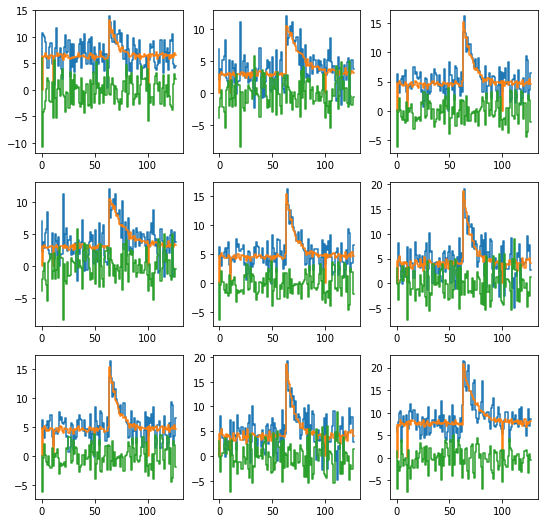

In [12]:
X_test_true = X_test[y_test == 1]
X_pred_true = autoencoder.predict(X_test_true)

x = np.arange(128)
fig, axs = plt.subplots(3,3,figsize=(9,9))

for i in range(3):
    for j in range(3):
        axs[i,j].step(x,X_test_true[(i+1)+(j+1)])
        axs[i,j].step(x,X_pred_true[(i+1)+(j+1)]);
        axs[i,j].step(x,X_pred_true[(i+1)+(j+1)] - X_test_true[(i+1)+(j+1)])

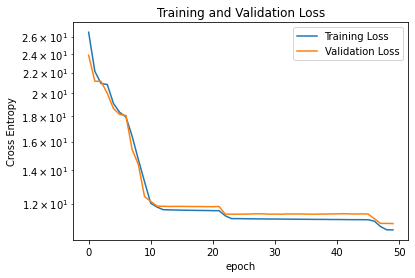

In [13]:
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')

#plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()